#### <span style='color:Red'> *Промежуточные и итоговые выводы обозначаются таким шрифтом.* </span>

In [1]:
#Подключаем библиотеки

#Для работы с данными
import numpy as np
import pandas as pd

#Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

#Для статистической обработки
from itertools import combinations
from scipy.stats import ttest_ind

#Графики в оформлении seaborn
sns.set()

In [2]:
#Промежуточные функции

def get_BoxPlot(x,y,df):
    '''
    Вывод графиков Box-Plot для параметра Y по группам X.
    Вход:
    * x - название столбца в DataFrame, по которому группируются данные;
    * y - название столбца в DataFrame, по которому строятся Box-Plot;
    * df - DataFrame.
    Выход:
    * None.
    '''
    #Место для Box-Plot и его настройки
    fig, ax = plt.subplots(figsize = (14, 4))
    #Box-Plot
    sns.boxplot(x=x, y=y, data=df, ax=ax, showmeans=True)
    #Разворот подписи по оси X
    plt.xticks(rotation=90)
    #Описание над графиком
    ax.set_title('Boxplot for ' + x)
    #Обновление графика
    plt.show()
    pass

def get_Hist(x,df):
    #Место для Box-Plot и его настройки
    fig, ax = plt.subplots(figsize = (14, 4))
    #Hist-Plot
    sns.distplot(df[x])
    #Обновление графика
    plt.show()
    pass

def get_stat_dif(x,y,df,alpha=0.05):
    '''
    Поиск статически значимых параметров.
    Вход:
    * x - название столбца в DataFrame, по которому группируются данные;
    * y - название столбца в DataFrame, по которому считается доверительный интервал;
    * df - DataFrame;
    * alpha=0.05 - уровень значимости.
    Выход:
    * Список из элементов [статически не значим, статически значим].
    '''
    #Список групп
    ind = df.loc[:, x].value_counts().index
    #Создание различных комбинаций из списка по 2
    combo = list(combinations(ind, 2))
    #Поиск
    for comb in combo:
        #Определение p-уровня значимости
        p = ttest_ind(df.loc[df.loc[:, x] == comb[0], y],
                     df.loc[df.loc[:, x] == comb[1], y]).pvalue
        #Проверка (знаменатель необходим для учета поправки Бонферрони)
        if p <= alpha / len(combo):
            print('Статистически значим: {}'.format(x))
            return [np.nan, x]
    else:
        print('Статистически не значим: {}'.format(x))
        return [x, np.nan]
    pass

def drop_out_num(x,df):
    '''
    Удаление строк, содержащих выбросы в столбце X количественных параметров.
    Вход:
    * x - название столбца в DataFrame, по которому удаляются выбросы;
    * df - DataFrame.
    Выход:
    * None.
    '''
    #Исходная длина DataFrame
    len_init = len(df)
    #Первый квартиль
    perc25 = df[x].quantile(0.25)
    #Третий квартиль
    perc75 = df[x].quantile(0.75)
    #Межквартильный размах
    IQR = perc75 - perc25
    #Удаление выбросов
    df = df.loc[df[x].between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)]
    #Конечная длина DataFrame
    len_end = len(df)
    #Вывод разности длин DataFrame
    print('Количество выбросов для параметра {}: {}.'.format(x, len_init-len_end))
    return df

def drop_out_nom(x,y,df):
    '''
    Удаление строк, содержащих выбросы в столбце X номинативных параметров.
    Вход:
    * x - название столбца в DataFrame, по которому группируются данные;
    * y - название столбца в DataFrame, по которому удаляются выбросы;
    * df - DataFrame.
    Выход:
    * None.
    '''
    #Исходная длина DataFrame
    len_init = len(df)
    #Функция для определения первого квартиля
    def q025(x):
        return x.quantile(0.25)
    #Функция для определения третьего квартиля
    def q075(x):
        return x.quantile(0.75)
    #Группировка и определение квартилей
    sub = df.groupby(x)[y].agg([q025,q075])
    #Создание промежуточного DataFrame
    df_sub = pd.DataFrame()
    #Поиск выбросов по группам
    for name, group in df.groupby(x)[y]:
        perc25 = sub.loc[name,'q025']
        perc75 = sub.loc[name,'q075']
        IQR = perc75 - perc25
        df_sub = pd.concat([df_sub,group.between(perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)])
    #Отсеивание выбросов
    df = df.loc[df_sub[0],:]
    #Конечная длина DataFrame
    len_end = len(df)
    #Вывод разности длин DataFrame
    print('Количество выбросов для параметра {}: {}.'.format(x, len_init-len_end))
    return df, len_init-len_end

def change_nan(x,y,df):
    '''
    Замена пропущенных значений NaN в столбце X на среднее по столбцу Y.
    Вход:
    * x - название столбца в DataFrame, где заменяются NaN;
    * y - название столбца в DataFrame, на среднее которого заменяется;
    * df - DataFrame.
    Выход:
    * Скорректированный DataFrame.
    '''
    #Среднее
    mas_mean = df.groupby(x)[y].agg('mean')
    #Выделение строк, содержащих NaN, в столбце X
    df_nan = df[df[x].isnull()]
    #Замена NaN на mean
    df.loc[df[x].isnull(), x] = df_nan.apply(lambda x: abs(x[y] - mas_mean).idxmin(),axis=1)
    return df

# Загрузка и осмотр данных

In [3]:
#Загрузка данные
df = pd.read_csv('stud_math.csv')
#Копирование для конечного сравнения
df_init = df.copy()
#Информация по столбцам
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

#### <span style='color:Red'> *Некоторые столбцы содержат пропущенные значения, выведем общее количество пропущенных значений.* </span>

In [4]:
#Количество пропущенных значений в каждом столбце
df.isnull().sum()

school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

#### <span style='color:Red'> *Проверим на присутствие значений, не описанных в описание к заданию.* </span>

In [5]:
#Количество уникальных значений
for col in df:
    print(df[col].value_counts())

GP    349
MS     46
Name: school, dtype: int64
F    208
M    187
Name: sex, dtype: int64
16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64
U    295
R     83
Name: address, dtype: int64
GT3    261
LE3    107
Name: famsize, dtype: int64
T    314
A     36
Name: Pstatus, dtype: int64
4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: Medu, dtype: int64
2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64
other       133
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64
other       197
services    102
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64
course        137
home          104
reputation    103
other          34
Name: reason, dtype: int64
mother    250
father     86
other      28
Name: guardian, dtype: int64
1.0    242
2.0     96
3.0     22
4.0      7
Name: traveltime, dtype: int64
2.0    194
1.0    103
3.0     64


#### <span style='color:Red'> *Столбцы Fedu и famrel содержат ошибочные значения (в соответствии с описанием DataFrame). Заменим их.* </span>

In [6]:
#Замена неправильных значений
df.loc[df['Fedu'] == 40,'Fedu'] = 4
df.loc[df['famrel'] == -1,'famrel'] = 1

#### <span style='color:Red'> *DataFrame содержит, как количественные, так и номинативные переменные. Обработаем отдельно каждый тип. Предварительно переведем часть переменных из количественного типа в номинативный (так как они могут иметь ограниченное количество значений и удобно будет обрабатывать их, как номинативные).* </span>

In [7]:
#Столбцы, содержащий все ранжированные значения
new_nom = df.select_dtypes(include=['float64', 'int64']).columns.drop(['score','age','absences'])
#Перевод переменной в номинативный тип
for col in new_nom:
    df[col] = df[col].apply(lambda x: str(x) if str(x) != 'nan' else x)
#Столбцы содержащие количественные и номинативные переменные
col_nom = df.select_dtypes(include=['object']).columns
col_num = df.select_dtypes(include=['float64', 'int64']).columns
col_num = col_num[::-1]

# Обработка количественных параметров

#### <span style='color:Red'> *Предварительно заменим все значения в столбце Score на медианное (не среднее, так как среднее будет дробным, а столбец Score содержит только значения кратные 5 - для красоты).* </span>

In [8]:
#Обработка столбца Score
median_score = df['score'].median()
df.loc[df['score'].isna(),'score'] = median_score

In [9]:
#Удаляем столбец с Score
col_num = col_num.drop('score')

In [10]:
#Замена пропущенных значений на среднее по Score для каждой группы
for col in col_num:
    df = change_nan(col,'score',df)

In [11]:
#Удаление выбросов
for col in col_num:
    df = drop_out_num(col,df)

Количество выбросов для параметра absences: 22.
Количество выбросов для параметра age: 1.


# Обработка номинативных параметров

In [12]:
#Замена пропущенных значений на среднее по Score для каждой группы
for col in col_nom:
    df = change_nan(col,'score',df)

In [13]:
#Распределение по каждому параметру
for col in col_nom:
    print(df.groupby(col)['score'].agg('describe'),end='\n'*3)

        count       mean        std  min   25%   50%   75%    max
school                                                           
GP      327.0  52.507645  22.878965  0.0  45.0  55.0  70.0  100.0
MS       45.0  49.666667  21.383936  0.0  40.0  50.0  65.0   95.0


     count       mean        std  min   25%   50%   75%    max
sex                                                           
F    194.0  49.768041  22.979441  0.0  40.0  55.0  65.0   95.0
M    178.0  54.775281  22.150106  0.0  45.0  55.0  70.0  100.0


         count       mean        std  min   25%   50%   75%    max
address                                                           
R         81.0  45.061728  23.123227  0.0  35.0  50.0  60.0   95.0
U        291.0  54.140893  22.212549  0.0  45.0  55.0  70.0  100.0


         count       mean        std  min   25%   50%   75%    max
famsize                                                           
GT3      262.0  50.362595  23.233823  0.0  40.0  55.0  65.0  100.0
LE3      

       count       mean        std  min   25%   50%    75%    max
goout                                                            
1.0     21.0  47.857143  26.766183  0.0  50.0  55.0  65.00   85.0
2.0     99.0  55.858586  22.991130  0.0  50.0  60.0  72.50  100.0
3.0    124.0  55.120968  21.121635  0.0  45.0  55.0  70.00   95.0
4.0     80.0  49.562500  21.021293  0.0  40.0  50.0  65.00   95.0
5.0     48.0  43.125000  24.356069  0.0  30.0  50.0  56.25   90.0


        count       mean        std  min    25%   50%   75%    max
health                                                            
1.0      46.0  61.195652  20.525994  0.0  50.00  65.0  75.0   95.0
2.0      40.0  51.375000  26.335788  0.0  45.00  55.0  70.0  100.0
3.0      95.0  48.684211  20.925533  0.0  40.00  50.0  60.0   95.0
4.0      58.0  50.948276  23.007567  0.0  41.25  52.5  65.0   95.0
5.0     133.0  52.293233  22.817717  0.0  40.00  55.0  70.0   90.0




#### <span style='color:Red'> *Часть значений содержит выбросы. Будем удалять их итерационно, пока каждый из номинативных параметров не потеряет все выбросы по столбцу Score.* </span>

In [14]:
#Удаление выбросов
dL = -1
while dL != 0:
    print('Новая итерация.')
    dL = 0
    for col in col_nom:
        df, dl = drop_out_nom(col,'score',df)
        dL += dl
    print('Количество выбросов {}.'.format(dL))
    print()

Новая итерация.
Количество выбросов для параметра school: 36.
Количество выбросов для параметра sex: 0.
Количество выбросов для параметра address: 1.
Количество выбросов для параметра famsize: 0.
Количество выбросов для параметра Pstatus: 0.
Количество выбросов для параметра Medu: 2.
Количество выбросов для параметра Fedu: 7.
Количество выбросов для параметра Mjob: 0.
Количество выбросов для параметра Fjob: 6.
Количество выбросов для параметра reason: 0.
Количество выбросов для параметра guardian: 0.
Количество выбросов для параметра traveltime: 4.
Количество выбросов для параметра studytime: 3.
Количество выбросов для параметра failures: 1.
Количество выбросов для параметра schoolsup: 0.
Количество выбросов для параметра famsup: 0.
Количество выбросов для параметра paid: 0.
Количество выбросов для параметра activities: 1.
Количество выбросов для параметра nursery: 1.
Количество выбросов для параметра studytime, granular: 0.
Количество выбросов для параметра higher: 0.
Количество выбро

#### <span style='color:Red'> *Зададим уровень значимости 5% и выделим лишние столбцы.* </span>

In [15]:
#Определяем статистически не значимые результаты
res_stat = []
for col in col_nom:
    res_stat += get_stat_dif(col,'score',df)

Статистически не значим: school
Статистически не значим: sex
Статистически значим: address
Статистически не значим: famsize
Статистически не значим: Pstatus
Статистически значим: Medu
Статистически значим: Fedu
Статистически значим: Mjob
Статистически не значим: Fjob
Статистически не значим: reason
Статистически значим: guardian
Статистически не значим: traveltime
Статистически не значим: studytime
Статистически значим: failures
Статистически значим: schoolsup
Статистически значим: famsup
Статистически не значим: paid
Статистически не значим: activities
Статистически не значим: nursery
Статистически не значим: studytime, granular
Статистически значим: higher
Статистически значим: internet
Статистически не значим: romantic
Статистически значим: famrel
Статистически значим: freetime
Статистически не значим: goout
Статистически значим: health


# Последующая обработка

In [16]:
#Выделение статически значимых номинативных параметров
list_stat = list(np.array(res_stat).reshape(int(len(res_stat) / 2), 2)[:,1])
list_stat = [x for x in list_stat if x != 'nan']
#Удаление статически не значимых результатов
cols = list(col_num) + list_stat + ['score']
df = df[cols]

In [17]:
#Определение корреляции
corr_matr = df.corr()
#Граничное значение
corr_kr = 0.75
#Выделение комбинации параметров
mas = []
for i in corr_matr.columns:
    for j in corr_matr.index:
        if i != j and abs(corr_matr.loc[j,i]) > corr_kr:
            mas += [[i,j]]
print('Список коррелирующих параметров: {}'.format(mas))

Список коррелирующих параметров: []


#### <span style='color:Red'> *Дополнительная проверка.* </span>

In [18]:
#Проверка - Количество NaN
df.isnull().sum()

absences     0
age          0
address      0
Medu         0
Fedu         0
Mjob         0
guardian     0
failures     0
schoolsup    0
famsup       0
higher       0
internet     0
famrel       0
freetime     0
health       0
score        0
dtype: int64

In [19]:
#Проверка - Количество удаленных значений (по выбросам)
print('Количество выбросов: {}.'.format(len(df_init) - len(df)))

Количество выбросов: 114.


# Анализ

#### <span style='color:Red'> *Для финального вывода построим Box-Plot по каждому номинативному параметру.* </span>

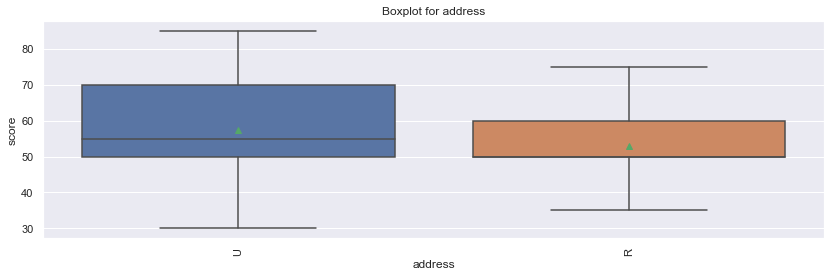

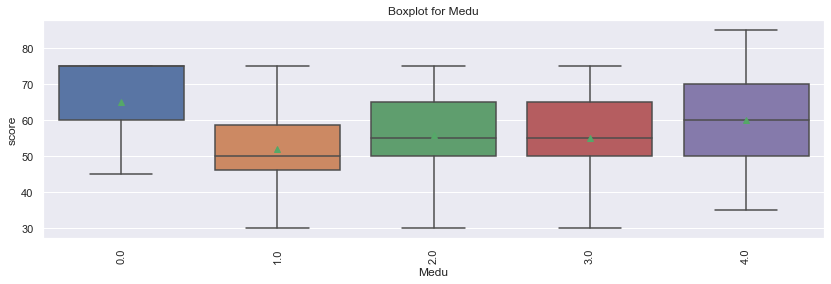

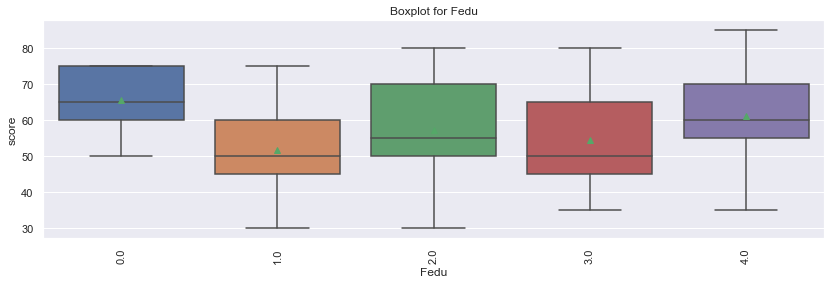

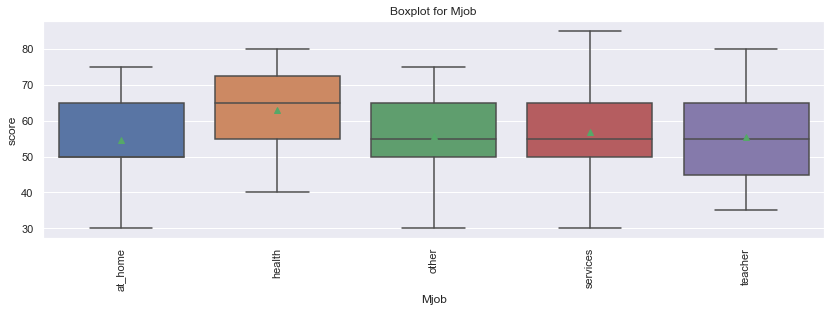

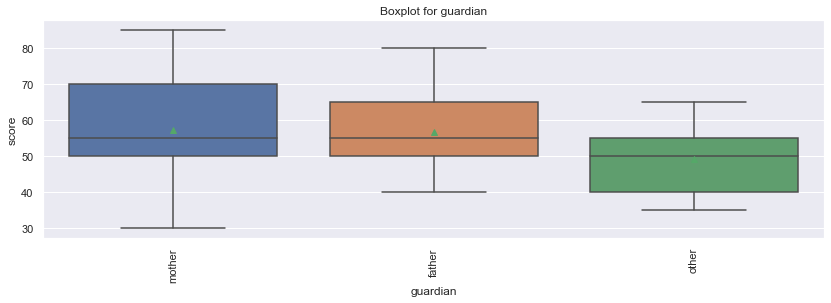

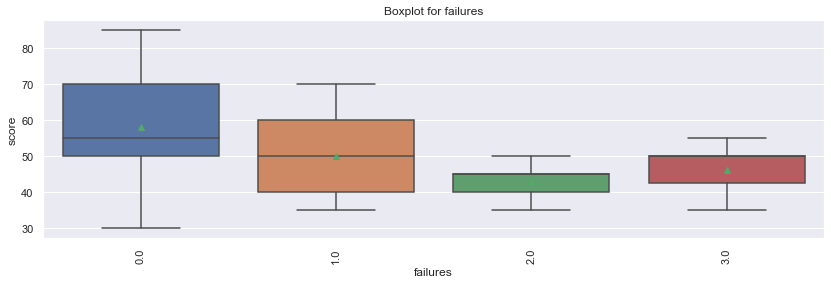

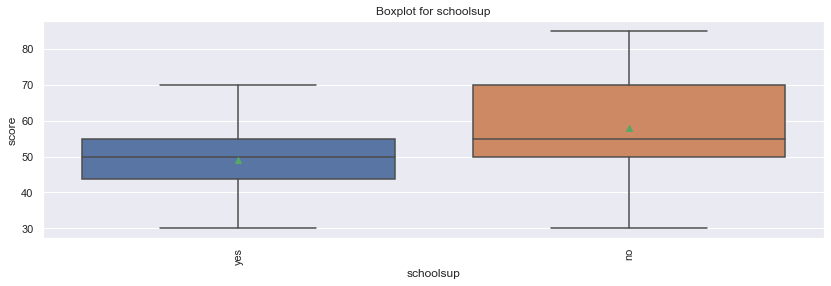

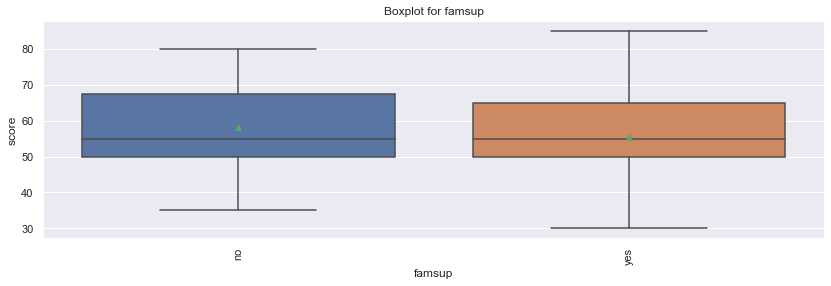

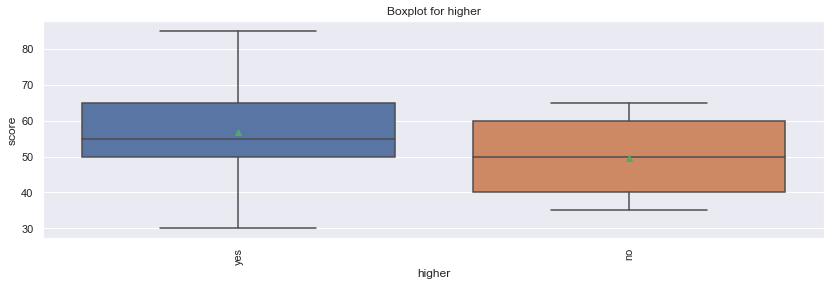

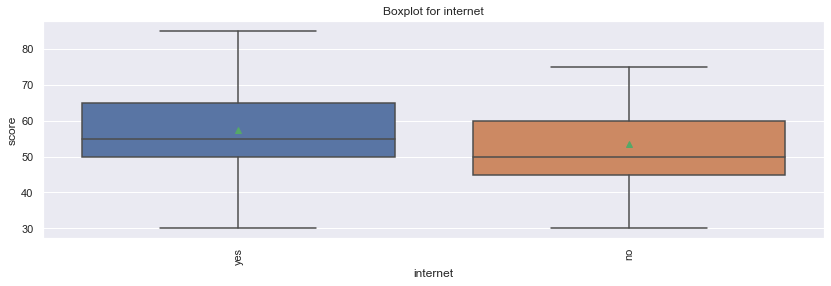

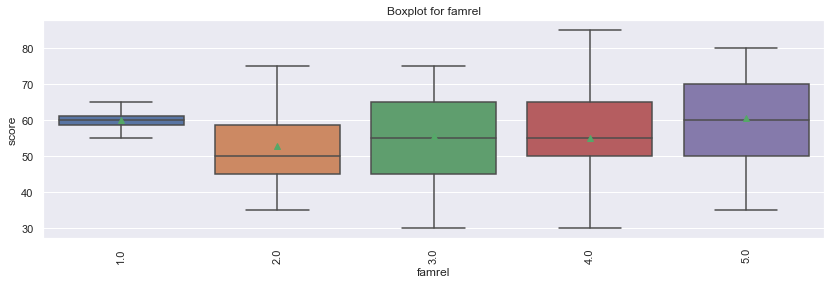

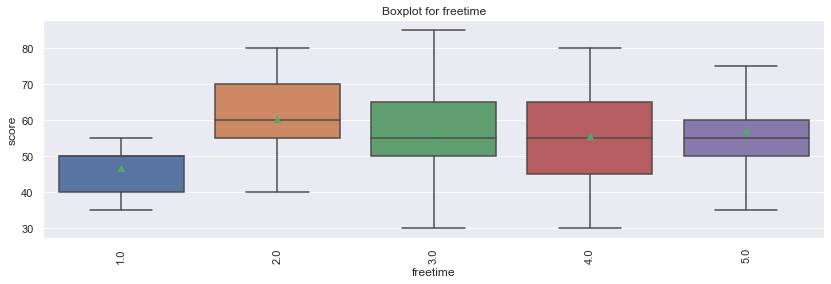

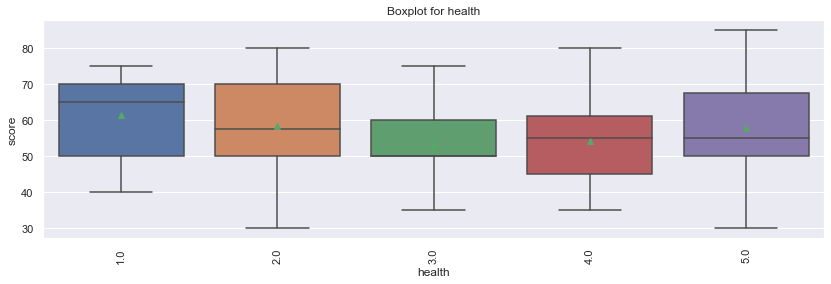

In [20]:
#Box-Plot для каждого параметра
for col in list_stat:
    get_BoxPlot(col,'score',df)

#### <span style='color:Red'> *Убедимся еще раз, что нет коррелирующих параметров, построив тепловую карту матрицы корреляций.* </span>

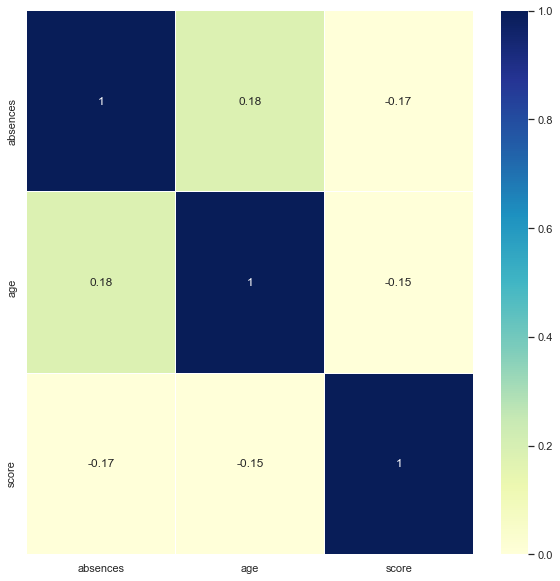

In [21]:
#Размер
plt.figure(figsize = (10,10))
#Тепловая карта матрицы корреляций
sns.heatmap(df.corr(),annot=True, vmin=0, vmax=1, linewidths=0.2, cmap="YlGnBu")

#### <span style='color:Red'> *Отобразим взаимосвязь количественных параметров на графике.* </span>

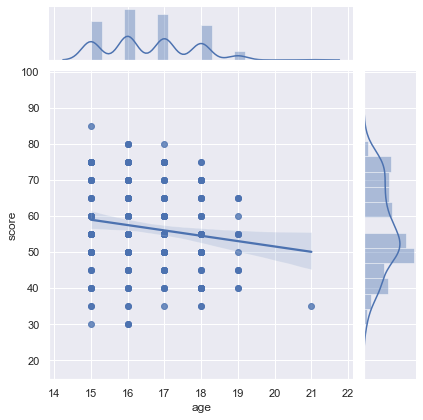

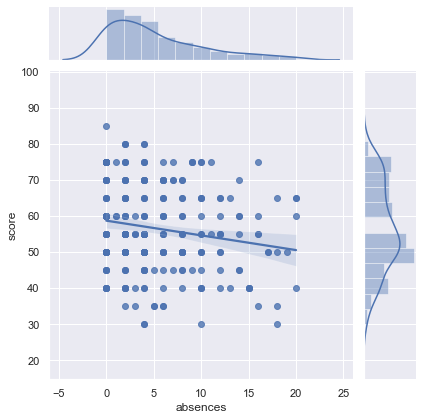

In [22]:
#Вывод Joint-Plot
for x in ['age','absences']:
    sns.jointplot(x=x,y='score',data=df, kind = 'reg')

# Выводы

### Код оформлен в соответствии с pep-8.
### Проведена первичная обработка данных:
##### * заменены неправильные значения - столбцы Fedu и famrel содержали ошибочные значения;
##### * удалены выбросы - количество выбросов 114;
##### * заменены пропущенные значения в столбце Score - замена NaN велась на медианное значение столбца Score;
##### * заменены пропущенные значения в остальных столбцах - замена NaN в строке велась на группы (значения), среднее Score которых по всему DataFrame было близко к значению Score исходной строки;
##### * часть признаков преобразована в другой тип - большинство исходных количественных признаков преобразовано в номинативные, так как они могут иметь сильно ограниченное количество значений, что позволяет разбить их на группы и обрабатывать их, как номинативные признаки;
##### * отобраны статистически значимые признаки (при уровне значимости 0.05);
##### * отобраны не коррелирующие параметры - среди трех оставшихся количественных параметров нет коррелирующих.
### Отсеянные параметры (как статически не значимые, так и коррелирующие с другими параметрами):
##### * sex, famsize, Pstatus, Fjob, reason, traveltime, studytime, paid, activities, nursery, studytime, granular, romantic, goout.
### Анализ оставшихся номинативных параметров:
##### * address - городские (U) дети имеют более высокий средний балл в сравнении с остальными (R). Также городские (U) могут сдать, как на более высокий балл, так и на более низкий, в то время, как остальные (R) сдают в основном на средний балл (дисперсия для группы (R) меньше);
##### * Medu - повышенные баллы имеют те, чьи матери имеют либо высшее образование (4), либо не имеют его вовсе (0). Самые низкие баллы для тех, чьи матери окончили 1-4 класса (1). Также группа с (4) имеет вероятность получить низкий балл, помимо высокого (высокая дисперсия);
##### * Fedu - повышенные баллы имеют те, чьи отцы имеют либо высшее образование (4), либо окончили 5-9 классов (2), либо не имеют его вовсе (0). Самые низкие баллы для тех, чьи отцы окончили 1-4 класса (1). Также группы с (2, 4) имеет вероятность получить низкий балл, помимо высокого (высокая дисперсия);
##### * Mjob - школьники с матерями, работающими по проффесиям врачей (health) имеют самый высокий средний балл. Чьи матери работают в сервисе (services) имеют самый высокий разброс по результатам. Худшие группы: не работает (at_home), другое (other);
##### * guardian - чей опекун не мама и не папа (other) имеют самый низкий балл в среднем. Средний балл для тех, чей опекун мама (mother) или папа (father) примерно равен. При этом школьники, чей опекун мать (mother) могут, как получить самый высокий балл, так и самый низкий (высокая дисперсия);
##### * failures - предварительно отбросим группу (0). Чем меньше количество неудач, тем выше средний балл. Далее рассмотрим группу (0): в ней есть школьники, имеющие как больше трех неудач, так и ноль, поэтому скорее всего более высокие значения свойственны тем, у кого вообще нет неудач, а более низкие тем, кто имеет их больше трех;
##### * schoolsup - дети, имеющие дополнительную образовательную поддержку в школе, имеют более низкий балл (скорее всего потому, что данная поддержка свойственна ученикам с низкой успеваемостью);
##### * famsup - дети имеют в среднем одинаковый балл вне зависимости от того, имеют они поддежку дома или нет, но те, кто имеют могут получить балл, как выше, так и ниже (первое свойственно для тех, кто занимается дополнительно сверх нормы, а второе тем, кто отстает и занимается дополнительно дома);
##### * higher - те школьники, кто хочет получить высшее образование, в среднем имеют более высокий балл;
##### * internet - те школьники, кто имеет доступ к интернету, в среднем имеют более высокий балл;
##### * famrel - можно проследить тенденцию, что с увеличением качества отношений в семье повышается и среднее значение балла. Понижение максимального балла при очень хороших отношениях (5) скорее всего объясняется тем, что хорошие условия расслабляют. Повышение среднего балла при самых плохих условия может быть объяснено, что школьники хотят выбраться из этих самых условий, или выборка (в данном случае 4 человека) слишком мала;
##### * freetime - средний балл растет с уменьшением количества свободного времени (за исключением группы (1)). Группа (1) либо слишком мала (9 человек), либо полное отсутствие свободного времени рещко способствует снижению балла;
##### * health.
### Анализ оставшихся номинативных параметров:
##### * age - как видно с Joint-Point взаимосвязи между возрастом и набранными баллами нету;
##### * absences - как видно с Joint-Point есть малая взаимосвязь между количеством пропущенных занятий и набранными баллами: чем выше первое, тем ниже второе.